In [260]:
'''
Ali Rabiee 99210389
HW4_Solutions
'''
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import scipy.ndimage as ndi
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import data
from skimage.feature import match_descriptors, ORB, plot_matches
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
import skimage.feature as sf
from google.colab.patches import cv2_imshow

In [261]:
#Problem_1 : Compute Harris Corner Detection

def Harris_Corner(img, k, offset): #Offeset = determine size of a window
  img_gray = rgb2gray(img)
  #(a)Compute image Gradients using Sobel operator
  sobelx = cv2.Sobel(img_gray,cv2.CV_64F,1,0,ksize=5)
  sobely = cv2.Sobel(img_gray,cv2.CV_64F,0,1,ksize=5)
  
  #(b)Compute the covariance matrix
  Ixx = ndi.gaussian_filter(sobelx * sobelx, sigma=1)
  Ixy = ndi.gaussian_filter(sobelx * sobely, sigma=1)
  Iyy = ndi.gaussian_filter(sobely * sobely, sigma=1)
  detH = Ixx * Iyy - Ixy * Ixy
  traceH = Ixx + Iyy
  harris_response = detH - k * traceH ** 2

  #Sum of squares
  for y in range(offset, img.shape[1]):
    for x in range(offset, img.shape[0]):
        sum_xx = np.sum(Ixx[y - offset : y + 1 + offset, x - offset : x + 1 + offset])
        sum_yy = np.sum(Iyy[y - offset : y + 1 + offset, x - offset : x + 1 + offset])
        sum_xy = np.sum(Ixy[y - offset : y + 1 + offset, x - offset : x + 1 + offset])

  #(c)Compute Harris Responce
  det = sum_xx * sum_yy - sum_xy ** 2
  trace = sum_xx + sum_yy
  r = det - k * trace ** 2

  #(d)Find Peaks
  corners = np.copy(img)
  for i, r1 in enumerate(harris_response):
    for j, r in enumerate(r1):
      if r > 0:
        corners[i, j] = [0, 0, 255]
  
  return corners, harris_response

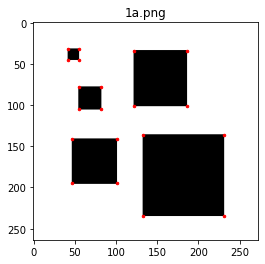

In [262]:

#(e)Boxes
#Read image
img = imread('Boxes.png')

#Find corners using Harris Corner
corners, harris_response = Harris_Corner(img, 0.05, 0)

#Showing result
corners = sf.corner_peaks(harris_response)
fig, IMG = plt.subplots()
IMG.imshow(img)
IMG.plot(corners[:, 1], corners[:, 0], '.r', markersize = 5)
plt.title('1a.png')
plt.savefig('1a.png')

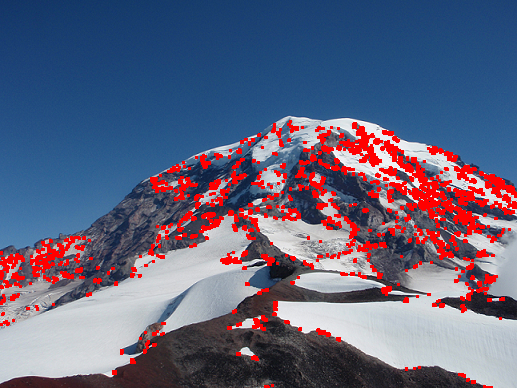

True

In [263]:
#(f)Rainier1
img = cv2.imread('Rainier1.png')
img_gray = rgb2gray(img)
img_gray = np.float32(img_gray)
dst = cv2.cornerHarris(img_gray, 2, 3, 0.05)
dst = cv2.dilate(dst, None)
img[dst > 0.01 * dst.max()] = [0, 0, 255]
cv2_imshow(img)
cv2.imwrite('1b.png',img)

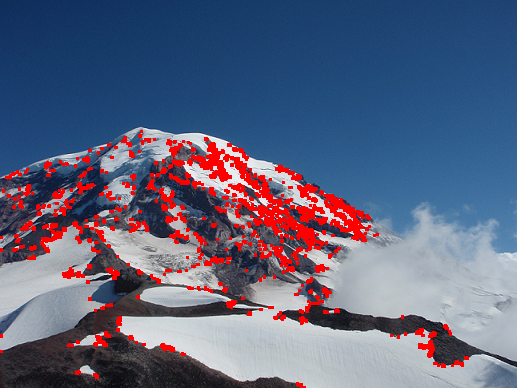

True

In [264]:
#(f)Rainier2
img = cv2.imread('Rainier2.png')
img_gray = rgb2gray(img)
img_gray = np.float32(img_gray)
dst = cv2.cornerHarris(img_gray, 2, 3, 0.05)
dst = cv2.dilate(dst, None)
img[dst > 0.01 * dst.max()] = [0, 0, 255]
cv2_imshow(img)
cv2.imwrite('1c.png',img)

In [265]:
#Problem_2 : Matching the interest points
#Part a,b,c,d

#using ORB and BFmatcher

def findMatches(img1, img2):
  #Initiate SIFT detector
  orb = cv2.ORB_create(nfeatures=500)
  #Find the keypoints and descriptors with SIFT
  kp1, des1 = orb.detectAndCompute(img1, None)
  kp2, des2 = orb.detectAndCompute(img2, None)
  #Create BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  #Match descriptor
  matches = bf.match(des1, des2)
  #Sort them in the order of their distance
  matches = sorted(matches, key = lambda x: x.distance)
  #Draw first 30 matches
  img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:30], None)
  return img3


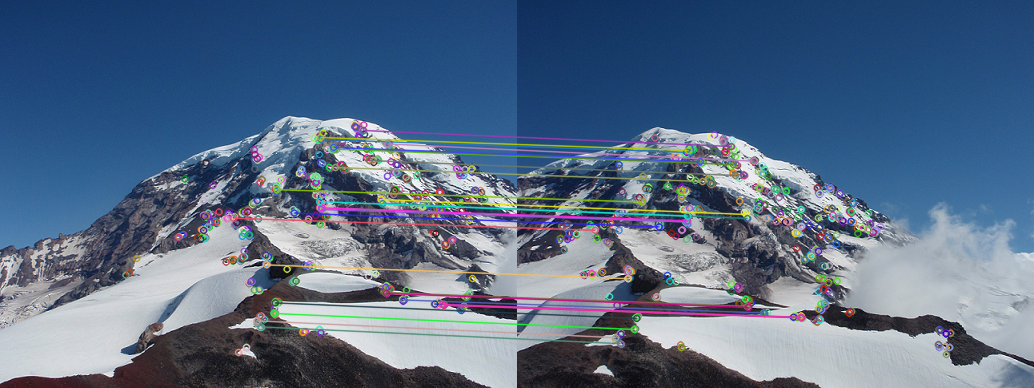

In [266]:
#Testing my def in Rainier1 & Rainier2
img1 = cv2.imread('Rainier1.png',1)
img2 = cv2.imread('Rainier2.png',1)
img3 = findMatches(img1, img2)
cv2_imshow(img3)

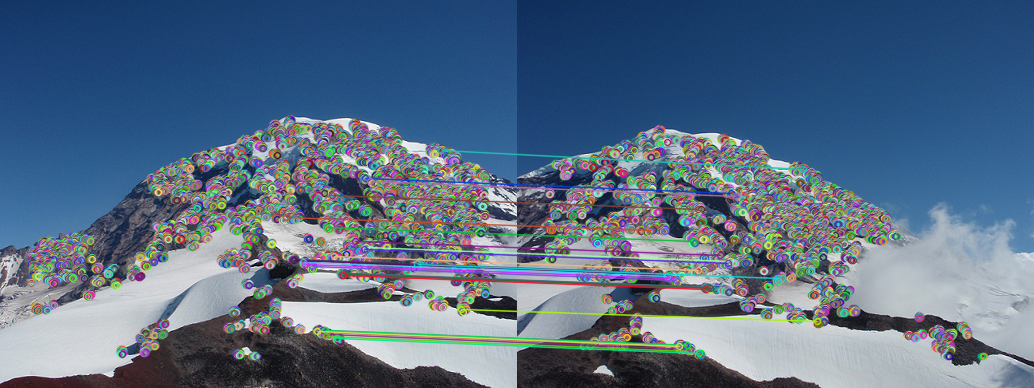

True

In [267]:
#Part(e) : Compute the Harris corner detector and find matches without using RANSAC

#Read images
img1 = cv2.imread('Rainier1.png', 1)
img2 = cv2.imread('Rainier2.png', 1)

#Gray images
img1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

#Find corners of 'Rainier1.png' using Harris Corner detector
img1_float = np.float32(img1_gray)
dst1 = cv2.cornerHarris(img1_float, 2, 3, 0.05)
dst1 = cv2.dilate(dst1, None)

#For each dst1 larger than threshold, make a keypoint out of it
kp1 = np.argwhere(dst1 > 0.01 * dst1.max())
kp1 = [cv2.KeyPoint(x[1], x[0], 1) for x in kp1]

#Find corners of 'Rainier2.png' using Harris Corner detector
img2_float = np.float32(img2_gray)
dst2 = cv2.cornerHarris(img2_float, 2, 3, 0.05)
dst2 = cv2.dilate(dst2, None)

#For each dst2 larger than threshold, make a keypoint out of it
kp2 = np.argwhere(dst2 > 0.01 * dst2.max())
kp2 = [cv2.KeyPoint(x[1], x[0], 1) for x in kp2]

#Initiate ORB detector
orb = cv2.ORB_create()

#Compute the descriptors with ORB
kp1, des1 = orb.compute(img1_gray, kp1)
kp2, des2 = orb.compute(img2_gray, kp2)

#Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

#Match descriptor
matches = bf.match(des1, des2)

#Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

#Draw first 30 matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:30], None)
cv2_imshow(img3)
cv2.imwrite('2a.png',img)

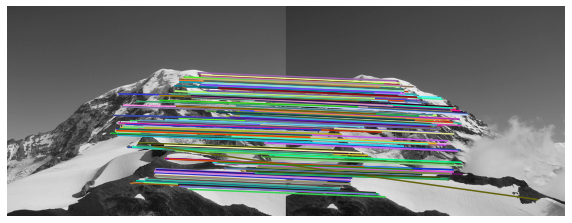

<Figure size 432x288 with 0 Axes>

In [268]:
#Part(f) : Compute the Harris corner detector and find matches with using RANSAC

img1, img2 = map(rgb2gray, (img1, img2))

#Feature correspondences between 2 images
descriptor_extractor = ORB()
descriptor_extractor.detect_and_extract(img1)
kp1 = descriptor_extractor.keypoints
des1 = descriptor_extractor.descriptors
descriptor_extractor.detect_and_extract(img2)
kp2 = descriptor_extractor.keypoints
des2 = descriptor_extractor.descriptors
matches = match_descriptors(des1, des2,
                            cross_check=True)

#Epipolar geometry between 2 images with using RANSAC
model, inliers = ransac((keypoints_left[matches[:, 0]],
                         keypoints_right[matches[:, 1]]),
                        FundamentalMatrixTransform, min_samples=8,
                        residual_threshold=1, max_trials=5000)

inlier_kp1 = kp1[matches[inliers, 0]]
inlier_kp2 = kp2[matches[inliers, 1]]

#Showing Result
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_matches(ax, img1, img2, kp1, kp2,
             matches[inliers], only_matches=True)
ax.axis("off")
fig.frameon=False
fig.set_figwidth(10)
plt.show()
plt.savefig('2b.png')

In [269]:
#Problem_3

#Read images
img1 = cv2.imread('Rainier1.png', 1)
img2 = cv2.imread('Rainier2.png', 1)

#Gray images
img1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

#Find corners of 'Rainier1.png' using Harris Corner detector
img1_float = np.float32(img1_gray)
dst1 = cv2.cornerHarris(img1_float, 2, 3, 0.05)
dst1 = cv2.dilate(dst1, None)

#For each dst1 larger than threshold, make a keypoint out of it
kp1 = np.argwhere(dst1 > 0.01 * dst1.max())
kp1 = [cv2.KeyPoint(x[1], x[0], 1) for x in kp1]

#Find corners of 'Rainier2.png' using Harris Corner detector
img2_float = np.float32(img2_gray)
dst2 = cv2.cornerHarris(img2_float, 2, 3, 0.05)
dst2 = cv2.dilate(dst2, None)

#For each dst2 larger than threshold, make a keypoint out of it
kp2 = np.argwhere(dst2 > 0.01 * dst2.max())
kp2 = [cv2.KeyPoint(x[1], x[0], 1) for x in kp2]

#Initiate ORB detector
orb = cv2.ORB_create()

#Compute the descriptors with ORB
kp1, des1 = orb.compute(img1_gray, kp1)
kp2, des2 = orb.compute(img2_gray, kp2)

#Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

#Match descriptor
matches = bf.match(des1, des2)

#Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

In [270]:
#Compute Homography using Harris corner and RANSAC
def findHomography(kp1, kp2, matches):
    img1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    img2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

    for i in range(0,len(matches)):
        img1_points[i] = kp1[matches[i].queryIdx].pt
        img2_points[i] = kp2[matches[i].trainIdx].pt

    homography, mask = cv2.findHomography(img1_points, img2_points, cv2.RANSAC, ransacReprojThreshold=2.0)

    return homography

#Compute hom and homInv
hom = findHomography(kp1, kp2, matches)
homInv = np.linalg.inv(hom)


In [271]:

def stitch(img1, img2, hom):
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  #Corners of img1 & img2
  corners1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  corners2 = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)
  #Project 4 corners of image2 onto image1
  project = cv2.perspectiveTransform(corners2, hom)

  points = np.concatenate((corners1, project), axis = 0)

  [x_min, y_min] = np.int32(points.min(axis = 0).ravel() - 0.5)
  [x_max, y_max] = np.int32(points.max(axis = 0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  result = cv2.warpPerspective(img2, H_translation.dot(hom), (x_max - x_min, y_max - y_min))
  result[translation_dist[1] : rows1 + translation_dist[1], translation_dist[0] : cols1 + translation_dist[0]] = img1

  return result
#Create stitchedImage 
stitchedImage = stitch(img1, img2, hom)


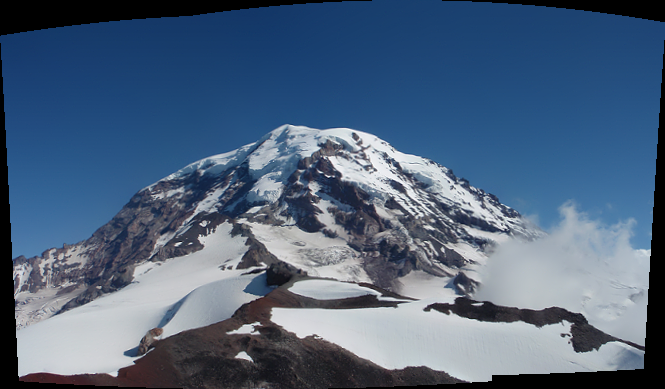

In [272]:
#Showing result
stitcher = cv2.Stitcher.create()
status, stitchedImage =stitcher.stitch((img1,img2))
cv2_imshow(stitchedImage)
cv2.imwrite('3.png', stitchedImage)

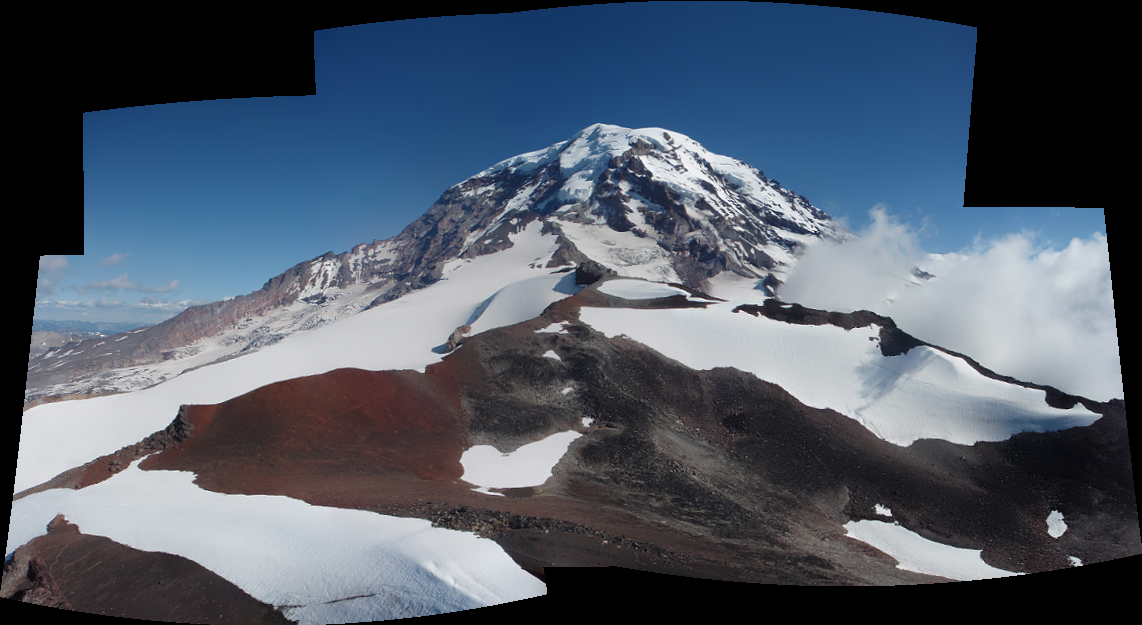

In [273]:
#Problem_4
#Part(a)

#Read images
img1 = cv2.imread("Rainier1.png")
img2 = cv2.imread("Rainier2.png")
img3 = cv2.imread("Rainier3.png")
img4 = cv2.imread("Rainier4.png")
img5 = cv2.imread("Rainier5.png")
img6 = cv2.imread("Rainier6.png")

#Stitch Images using OpenCV library
stitcher=cv2.Stitcher.create()
status, result =stitcher.stitch((img1,img2,img3,img4,img5,img6))
cv2_imshow(result)

In [274]:
#Part(b)
